In [102]:
import numpy as np
import pandas as pd
from sklearn import datasets
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.utils.validation import check_is_fitted, check_X_y
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

Load Dataset

In [103]:
# Load the Iris dataset
iris = datasets.load_iris()
X, y = iris.data, iris.target
labels = iris.target_names
# Drop the petal length and petal width features to form a 2D Iris dataset
X2d = iris.data[:, [0, 1]]
X_train, X_test, y_train, y_test = train_test_split(X2d, y , random_state=0)

In [104]:
#plot accuracy, classification_report and model_confusion_matrix
def plot_model(model, X, y, y_pred):
  accuracy = accuracy_score(y, y_pred)
  print('Accuracy : ', accuracy)
  print(classification_report(y, y_pred))
  model_confusion_matrix = confusion_matrix(y, y_pred)
  print(model_confusion_matrix)
  plot_confusion_matrix(model, X, y)

In [105]:
def plotDecisionBoundary(X, y, est, title):
  plt.close('all')
  plt.figure()
  cm = plt.cm.Set1
  x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
  y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
  h = 0.02
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))
  Z = est.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)
  plt.contourf(xx, yy, Z, cmap=cm, alpha=.8)
  plt.scatter(
      X[:, 0],
      X[:, 1],
      c=y,
      cmap=cm,
      edgecolors='k',
      alpha=1,
  )
  plt.title(title)
  plt.xlabel("Sepal Length")
  plt.ylabel("Sepal Width")
  # plt.legend(labels)

Naive Bayes

In [106]:
nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)
y_pred_train = nb_classifier.predict(X_train)
y_pred_test = nb_classifier.predict(X_test)

Training Accuracy

Accuracy :  0.8125
              precision    recall  f1-score   support

           0       1.00      0.97      0.99        37
           1       0.68      0.74      0.70        34
           2       0.77      0.73      0.75        41

    accuracy                           0.81       112
   macro avg       0.81      0.81      0.81       112
weighted avg       0.82      0.81      0.81       112

[[36  1  0]
 [ 0 25  9]
 [ 0 11 30]]


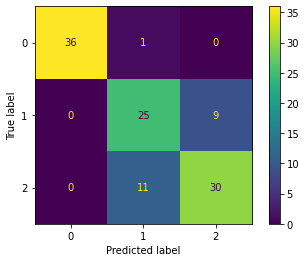

In [107]:
plot_model(nb_classifier, X_train, y_train, y_pred_train)

Plot Decision Boundary

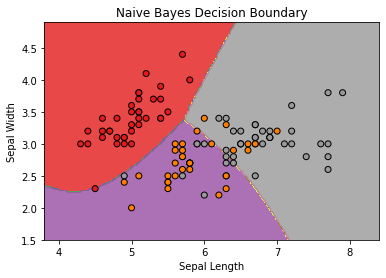

In [108]:
plotDecisionBoundary(X_train, y_train, nb_classifier, 'Naive Bayes Decision Boundary')

Testing Accuracy

Accuracy :  0.7631578947368421
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       0.71      0.75      0.73        16
           2       0.50      0.44      0.47         9

    accuracy                           0.76        38
   macro avg       0.74      0.73      0.73        38
weighted avg       0.76      0.76      0.76        38

[[13  0  0]
 [ 0 12  4]
 [ 0  5  4]]


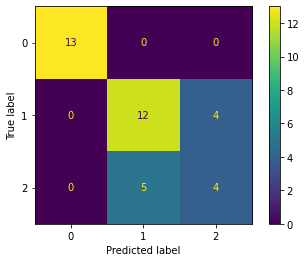

In [109]:
plot_model(nb_classifier, X_test, y_test, y_pred_test)

Plot Decision Boundary

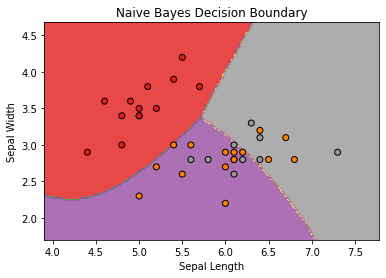

In [110]:
plotDecisionBoundary(X_test, y_test, nb_classifier, 'Naive Bayes Decision Boundary')

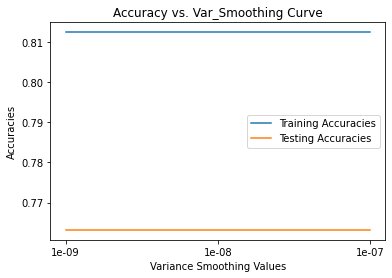

In [111]:
var_smoothing_vals = [1e-9, 1e-8, 1e-7]
train_accuracies = []
test_accuracies = []
for val in var_smoothing_vals:
  nb_var = GaussianNB(var_smoothing=val)
  nb_var.fit(X_train, y_train)
  y_pred_train = nb_var.predict(X_train)
  train_accuracy = accuracy_score(y_train, y_pred_train)
  train_accuracies.append(train_accuracy)
  y_pred_test = nb_var.predict(X_test)
  test_accuracy = accuracy_score(y_test, y_pred_test)
  test_accuracies.append(test_accuracy)

values = range(len(var_smoothing_vals))
plt.plot(values, train_accuracies, label = "Training Accuracies")
plt.plot(values, test_accuracies, label = "Testing Accuracies")
plt.xlabel("Variance Smoothing Values")
plt.xticks(values, var_smoothing_vals)
plt.ylabel("Accuracies")
plt.title("Accuracy vs. Var_Smoothing Curve")
plt.legend()
plt.show()

Develop Risk-based Bayesian Decision Theory Classifier (RBDTC)


In [112]:
class BayesianDecisionTheoryClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, estimator, riskMat, classMapping):
        self.estimator = estimator
        self.riskMat = riskMat
        self.classMapping = list(classMapping.items())

    def fit(self, X, y):
        X_checked, y_checked = check_X_y(X, y)
        self.classes_ = np.unique(y_checked)
        self.classes_names = np.array(self.classMapping)
        self.estimator_ = clone(self.estimator).fit(X_checked, y_checked)
        return self

    def predict_proba(self, X):
        check_is_fitted(self)
        prob = self.estimator_.predict_proba(X)
        probList = [(prob * self.riskMat[index]).sum(axis=1).reshape((-1, 1))
                    for index, c in enumerate(self.classes_)]
        prob = np.hstack(probList)
        return prob

    def predict(self, X):
        pred = self.predict_proba(X).argmin(axis=1)
        return self.classes_[pred]
      
    def predict_names(self, X):
        pred = self.predict_proba(X).argmin(axis=1)
        return self.classes_names[pred, 1]

Apply Risk-based Bayesian Decision Theory Classifier which takes Naïve Bayes Classifier as
base estimator and uses Table 3 as risk matrix

In [122]:
riskMat = np.array([
      [-10, -5, -5],
      [-5, -10, -5],
      [-5, -5, -100],
  ])
class_mapping = {
    0: "Setosa",
    1: "Versicolor",
    2: "Virginica"
}
bdtc = BayesianDecisionTheoryClassifier(nb_classifier, riskMat, class_mapping)
bdtc.fit(X_train, y_train)
bdtc_yPred_train = bdtc.predict(X_train)
bdtc_yPred_test = bdtc.predict(X_test)
bdtc_yPred_test_names = bdtc.predict_names(X_test)
print(bdtc_yPred_test)
print(bdtc_yPred_test_names)

[2 2 0 2 0 2 0 2 2 2 2 2 2 2 2 0 2 2 0 0 2 2 0 0 2 0 0 2 1 0 2 2 0 2 2 2 2
 2]
['Virginica' 'Virginica' 'Setosa' 'Virginica' 'Setosa' 'Virginica'
 'Setosa' 'Virginica' 'Virginica' 'Virginica' 'Virginica' 'Virginica'
 'Virginica' 'Virginica' 'Virginica' 'Setosa' 'Virginica' 'Virginica'
 'Setosa' 'Setosa' 'Virginica' 'Virginica' 'Setosa' 'Setosa' 'Virginica'
 'Setosa' 'Setosa' 'Virginica' 'Versicolor' 'Setosa' 'Virginica'
 'Virginica' 'Setosa' 'Virginica' 'Virginica' 'Virginica' 'Virginica'
 'Virginica']


Plot decision boundary and calculate precision, recall and accuracy for training and testing
set

Training Set

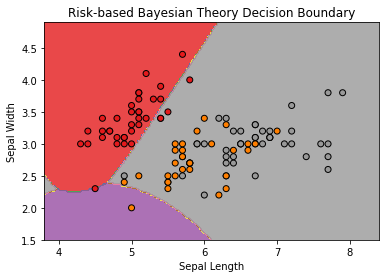

In [114]:
plotDecisionBoundary(X_train, y_train, bdtc, 'Risk-based Bayesian Theory Decision Boundary')

Accuracy :  0.6607142857142857
              precision    recall  f1-score   support

           0       1.00      0.86      0.93        37
           1       0.50      0.03      0.06        34
           2       0.53      1.00      0.69        41

    accuracy                           0.66       112
   macro avg       0.68      0.63      0.56       112
weighted avg       0.67      0.66      0.58       112

[[32  1  4]
 [ 0  1 33]
 [ 0  0 41]]


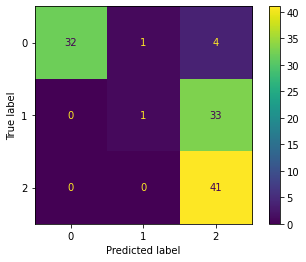

In [115]:
plot_model(bdtc, X_train, y_train, bdtc_yPred_train)

Testing Set

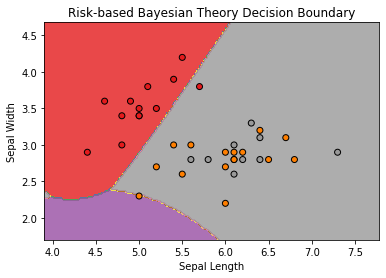

In [116]:
plotDecisionBoundary(X_test, y_test, bdtc, 'Risk-based Bayesian Theory Decision Boundary')

Accuracy :  0.5789473684210527
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        13
           1       1.00      0.06      0.12        16
           2       0.36      1.00      0.53         9

    accuracy                           0.58        38
   macro avg       0.79      0.66      0.54        38
weighted avg       0.85      0.58      0.50        38

[[12  0  1]
 [ 0  1 15]
 [ 0  0  9]]


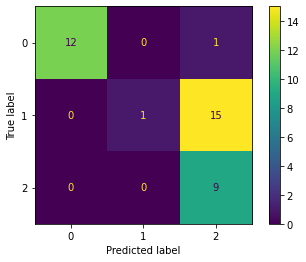

In [117]:
plot_model(bdtc, X_test, y_test, bdtc_yPred_test)